In [21]:
# import the required libraries
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import textwrap

In [22]:
# Now need to convert out dataset into the same format
datasets = ["Eurosat", "Caltech", "DTD", "Oxford Pets","AirCrafts", "Stanford Cars", "Oxford flowers", "SUN397", "ImageNet", "UCF", "FOOD"]
coop=[68.69,93.73, 54.24,94.47, 28.75, 68.13, 74.06, 72.51, 71.92, 67.46, 85.19]
cocoop=[71.21,95.84, 64.85, 96.43, 27.74, 72.01, 81.71, 78.27,  73.10, 77.64, 90.99]
clip = [60.03, 95.40, 56.37,94.12,  31.09, 68.65, 74.83, 72.23, 70.22, 73.85, 90.66]
our_method = [82.35, 96.02, 68.16,96.58,  36.50, 73.47, 82.56, 79.75, 73.47, 80.77, 91.38]

all_data = [clip, coop, cocoop, our_method]
df = pd.DataFrame(all_data, columns=datasets, index = ['CLIP', "CoOp",'Co-CoOp (Previous SOTA)', 'MaPLe (Ours)'])
df.index.rename('Method',inplace=True)
data = df
result = df

In [23]:
# this class is taken from the the source https://towardsdatascience.com/how-to-create-and-visualize-complex-radar-charts-f7764d0f3652
class ComplexRadar():
    """
    Create a complex radar chart with different scales for each variable
    Parameters
    ----------
    fig : figure object
        A matplotlib figure object to add the axes on
    variables : list
        A list of variables
    ranges : list
        A list of tuples (min, max) for each variable
    n_ring_levels: int, defaults to 5
        Number of ordinate or ring levels to draw
    show_scales: bool, defaults to True
        Indicates if we the ranges for each variable are plotted
    """
    def __init__(self, fig, variables, ranges, n_ring_levels=5, show_scales=True):
        # Calculate angles and create for each variable an axes
        # Consider here the trick with having the first axes element twice (len+1)
        angles = np.arange(0, 360, 360./len(variables))
        axes = [fig.add_axes([0.1,0.1,0.9,0.9], polar=True, label = "axes{}".format(i)) for i in range(len(variables)+1)]
        
        # Ensure clockwise rotation (first variable at the top N)
        for ax in axes:
            ax.set_theta_zero_location('N')
            ax.set_theta_direction(-1)
            ax.set_axisbelow(True)
        
        # Writing the ranges on each axes
        for i, ax in enumerate(axes):

            # Here we do the trick by repeating the first iteration
            j = 0 if (i==0 or i==1) else i-1
            ax.set_ylim(*ranges[j])
            # Set endpoint to True if you like to have values right before the last circle
            grid = np.linspace(*ranges[j], num=n_ring_levels, 
                               endpoint=False)
            gridlabel = ["{}".format(round(x,2)) for x in grid]
            gridlabel[0] = "" # remove values from the center
            lines, labels = ax.set_rgrids(grid, labels=gridlabel, angle=angles[j], fontsize=22)  # the values of scales
            
            ax.set_ylim(*ranges[j])
            ax.spines["polar"].set_visible(False)
            ax.grid(visible=False)
            
            if show_scales == False:
                ax.set_yticklabels([])

        # Set all axes except the first one unvisible
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            
        # Setting the attributes
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
        self.ax1 = axes[1]
        self.plot_counter = 0
        
        # Draw (inner) circles and lines
        self.ax.yaxis.grid()
        self.ax.xaxis.grid()

        # Draw outer circle
        self.ax.spines['polar'].set_visible(False)
        
        # ax1 is the duplicate of axes[0] (self.ax)
        # Remove everything from ax1 except the plot itself
        self.ax1.axis('off')
        self.ax1.set_zorder(9)
        
        # Create the outer labels for each variable
        l, text = self.ax.set_thetagrids(angles, labels=variables, fontsize=100, weight='bold')
        
        # Beautify them
        labels = [t.get_text() for t in self.ax.get_xticklabels()]
        labels = ['\n'.join(textwrap.wrap(l, 15, break_long_words=False)) for l in labels]
        self.ax.set_xticklabels(labels, fontsize=25)
        
        for t,a in zip(self.ax.get_xticklabels(),angles):
            if a == 0:
                t.set_ha('center')
            elif a > 0 and a < 180:
                t.set_ha('left')
            elif a == 180:
                t.set_ha('center')
            else:
                t.set_ha('right')

        self.ax.tick_params(axis='both', pad=15)


    def _scale_data(self, data, ranges):
        """Scales data[1:] to ranges[0]"""
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            assert (y1 <= d <= y2) or (y2 <= d <= y1)
        x1, x2 = ranges[0]
        d = data[0]
        sdata = [d]
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            sdata.append((d-y1) / (y2-y1) * (x2 - x1) + x1)
        return sdata
        
    def plot(self, data, color, *args, **kwargs):
        """Plots a line"""
        sdata = self._scale_data(data, self.ranges)
        if color == 'violet':
            self.ax1.plot(self.angle, np.r_[sdata, sdata[0]], color=color, linewidth=3, *args, **kwargs)
        else: self.ax1.plot(self.angle, np.r_[sdata, sdata[0]], color=color, linewidth=2, *args, **kwargs)
        self.plot_counter = self.plot_counter+1
    
    def fill(self, data, color, *args, **kwargs):
        """Plots an area"""
        sdata = self._scale_data(data, self.ranges)
        self.ax1.fill(self.angle, np.r_[sdata, sdata[0]], color=color, *args, **kwargs)
        
    def use_legend(self, *args, **kwargs):
        """Shows a legend"""
        leg= self.ax1.legend(fontsize=27, *args, **kwargs)
        # get the legend object
        # leg.set_weight('bold')

        # change the line width for the legend
        for line in leg.get_lines():
            line.set_linewidth(14.0)
    
    def set_title(self, title, pad=25, **kwargs):
        """Set a title"""
        self.ax.set_title(title,pad=pad, **kwargs)

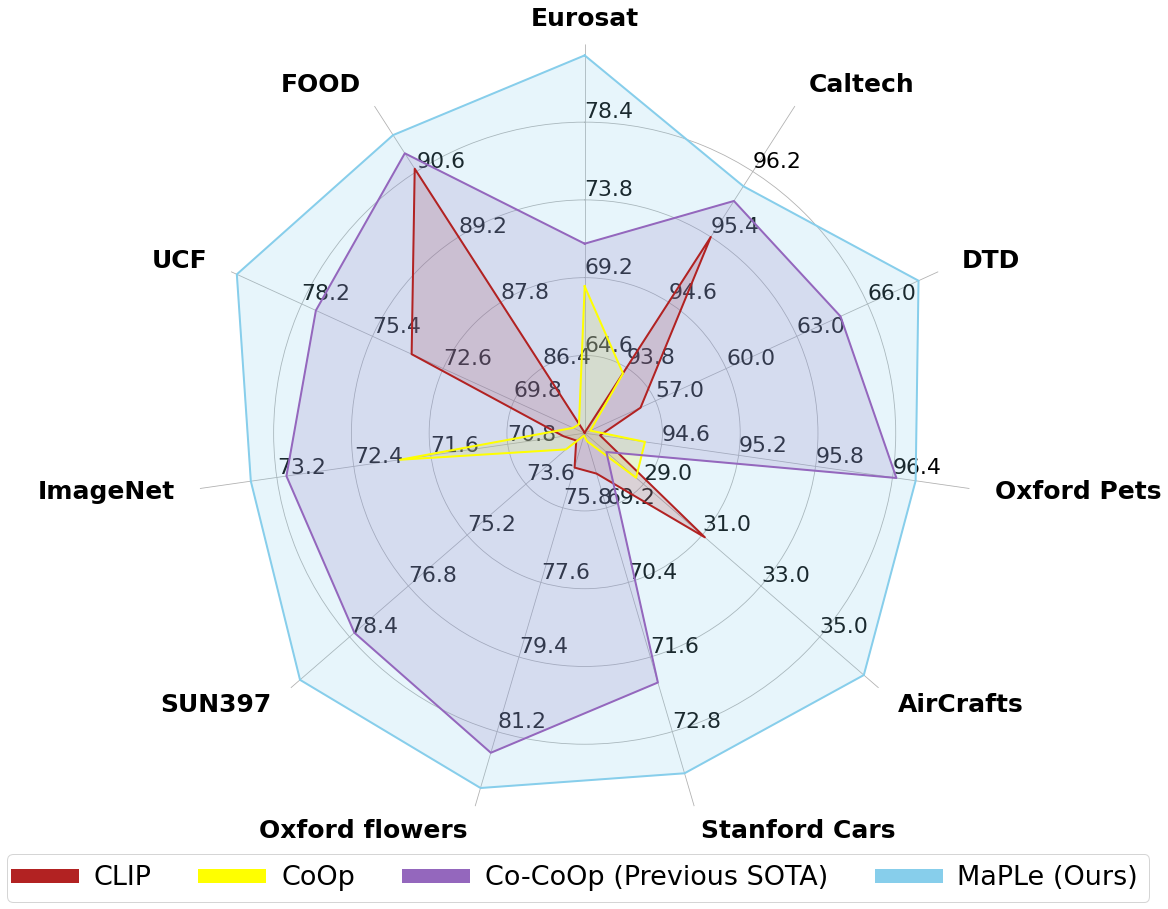

In [24]:
min_max_per_variable = data.describe().T[['min', 'max']]
min_max_per_variable['min'] = min_max_per_variable['min'].apply(lambda x: int(x))
min_max_per_variable['max'] = min_max_per_variable['max'].apply(lambda x: math.ceil(x))

variables = result.columns
ranges = list(min_max_per_variable.itertuples(index=False, name=None))   

fig1 = plt.figure(figsize=(12, 12))
radar = ComplexRadar(fig1, variables, ranges, show_scales=True)
colors = ['firebrick', 'yellow','tab:purple', 'skyblue']
for g, color in zip(result.index, colors):
    radar.plot(result.loc[g].values, label=f"{g}", color=color)
    radar.fill(result.loc[g].values, alpha=0.2, color=color)

# radar.set_title("Radar chart solution with different scales")
radar.use_legend(loc='lower left', bbox_to_anchor=(-0.26, -0.12),ncol=radar.plot_counter)
# plt.savefig("radar_plot.png", bbox_inches='tight', pad_inches=0, facecolor='white', transparent=False, dpi=500)
# plt.savefig("radar_plot.png", bbox_inches='tight', pad_inches=0, transparent=True, dpi=500)
plt.show() 